In [1]:
import dash
from dash import dcc
from dash import html
import plotly.express as px
from datetime import datetime
import pandas as pd
from dash.dependencies import Input, Output
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as smf
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
covid_data = pd.read_csv("../../../data/stage_4/covid_large.csv")
covid_data = covid_data[covid_data['countyFIPS']!=0]
covid_data

State  countyFIPS     County Name        Date  Num of Cases  \
573        AL        1001  autauga county  2020-01-22             0   
574        AL        1001  autauga county  2020-01-23             0   
575        AL        1001  autauga county  2020-01-24             0   
576        AL        1001  autauga county  2020-01-25             0   
577        AL        1001  autauga county  2020-01-26             0   
...       ...         ...             ...         ...           ...   
1829584    WY       56045   weston county  2021-08-12           700   
1829585    WY       56045   weston county  2021-08-13           700   
1829586    WY       56045   weston county  2021-08-14           705   
1829587    WY       56045   weston county  2021-08-15           705   
1829588    WY       56045   weston county  2021-08-16           705   

         Num of Deaths  population  
573                  0       55869  
574                  0       55869  
575                  0       55869  
576                  0       55869  
577                  0       55869  
...                ...         ...  
1829584              6        6927  
1829585              6        6927  
1829586              6        6927  
1829587              6        6927  
1829588              6        6927  

[1800366 rows x 7 columns]

In [3]:
from urllib.request import urlopen
from jupyter_dash import JupyterDash
from datetime import date

In [4]:
map_data = covid_data.groupby(['County Name','countyFIPS'])['population'].mean().reset_index()
map_data

County Name  countyFIPS  population
0     abbeville county       45001       24527
1        acadia parish       22001       62045
2      accomack county       51001       32316
3           ada county       16001      481587
4         adair county       19001        7152
...                ...         ...         ...
3137       yuma county        4027      213787
3138       yuma county        8125       10019
3139     zapata county       48505       14179
3140     zavala county       48507       11840
3141    ziebach county       46137        2756

[3142 rows x 3 columns]

In [5]:
map_data['Num of Cases'] = round(covid_data['Num of Cases']/map_data['population'] * 10000)
map_data['Num of Deaths'] = round(covid_data['Num of Deaths']/map_data['population'] * 10000)
map_data['Num of Cases'] = map_data['Num of Cases'].fillna(0)
map_data['Num of Deaths'] = map_data['Num of Deaths'].fillna(0)
map_data

County Name  countyFIPS  population  Num of Cases  Num of Deaths
0     abbeville county       45001       24527           0.0            0.0
1        acadia parish       22001       62045           0.0            0.0
2      accomack county       51001       32316           0.0            0.0
3           ada county       16001      481587           0.0            0.0
4         adair county       19001        7152           0.0            0.0
...                ...         ...         ...           ...            ...
3137       yuma county        4027      213787          86.0            1.0
3138       yuma county        8125       10019        1869.0           25.0
3139     zapata county       48505       14179        1335.0           18.0
3140     zavala county       48507       11840        1614.0           21.0
3141    ziebach county       46137        2756        6985.0           91.0

[3142 rows x 5 columns]

In [6]:
def generate_x_values(df):
    mylist = []
    for i in range(1,(len(df)+1)):
        mylist.append(i)
    df['x_values'] = mylist
    return df

In [7]:
def get_Data_statewise(state, start_date, end_date, case_type):
    
    #covid_data_grp = []
    if case_type == 'Cases':
        if state == 'US':
            covid_data_grp = covid_data.groupby(['Date'])['Num of Cases'].sum().reset_index()
            covid_data_grp['Num of Cases'] = covid_data_grp['Num of Cases'].diff()
            covid_data_grp = covid_data_grp.drop([0])
            covid_data_grp['Num of Cases'] = covid_data_grp['Num of Cases'].astype(int)
        else:
            covid_data_state = covid_data[covid_data['State']==state]
            covid_data_grp = covid_data_state.groupby(['Date'])['Num of Cases'].sum().reset_index()
            covid_data_grp['Num of Cases'] = covid_data_grp['Num of Cases'].diff()
            covid_data_grp = covid_data_grp.drop([0])
            covid_data_grp['Num of Cases'] = covid_data_grp['Num of Cases'].astype(int)
    elif case_type == 'Deaths':
        if state == 'US':
            covid_data_grp = covid_data.groupby(['Date'])['Num of Deaths'].sum().reset_index()
            covid_data_grp['Num of Deaths'] = covid_data_grp['Num of Deaths'].diff()
            covid_data_grp = covid_data_grp.drop([0])
            covid_data_grp['Num of Deaths'] = covid_data_grp['Num of Deaths'].astype(int)
        else:
            covid_data_state = covid_data[covid_data['State']==state]
            covid_data_grp = covid_data_state.groupby(['Date'])['Num of Deaths'].sum().reset_index()
            covid_data_grp['Num of Deaths'] = covid_data_grp['Num of Deaths'].diff()
            covid_data_grp = covid_data_grp.drop([0])
            covid_data_grp['Num of Deaths'] = covid_data_grp['Num of Deaths'].astype(int)

    covid_final = covid_data_grp[(covid_data_grp['Date'] > start_date) & (covid_data_grp['Date'] < end_date)]
    covid_data_x=generate_x_values(covid_final)
    
    return covid_data_x

In [8]:
def generate_plot(df,graph_type,state,case_type,mode_type):
    fig=go.Figure()
    if graph_type=='trend':
        
        poly_features = PolynomialFeatures(degree=4)
        x = smf.add_constant(df['x_values'])
        x_val = poly_features.fit_transform(x)
        y = ""
        if case_type == 'Cases':
            if mode_type =='log':
                y= np.absolute(np.log(df['Num of Cases']))
            if mode_type =='Avg':
                  df = df[(df['Num of Cases'] >= 0)]
                  df['Date'] = pd.to_datetime(df['Date'])
                  y= df['Num of Cases']
            else:
                y = abs(df['Num of Cases'])
        elif case_type == 'Deaths':
            if mode_type =='log':
                y= np.absolute(np.log(df['Num of Deaths']))
            if mode_type =='Avg':
                  df = df[(df['Num of Deaths'] >= 0)]
                  df['Date'] = pd.to_datetime(df['Date'])
                  y= df['Num of Deaths']
            else:
                y = abs(df['Num of Deaths'])
        if mode_type =='Avg' :
            fig = px.scatter(df, x="Date", y=y, trendline="rolling", trendline_options=dict(window=7),
                    title="7-day moving average")
            return dcc.Graph(figure = fig)
        else:
            title = "Trend Line and Regression Line for "
            yaxis = "Number of covid new: "
            df['bestfit_line'] = smf.OLS(y,x_val).fit().fittedvalues
            #fig=go.Figure()
            fig.add_trace(go.Scatter(name='Num of Cases', x=df['Date'], y=y, mode='lines'))
            fig.add_trace(go.Scatter(name='line of best fit', x=df['Date'], y=df['bestfit_line'], mode='lines'))
            fig.update_layout(title=title+state, xaxis_title="Number of Days", yaxis_title=yaxis+case_type,
            font=dict(
                family="Courier New, monospace",
                color="#7f7f7f"))
    elif graph_type == 'map':
        fig = px.choropleth_mapbox(map_data, geojson=counties, locations=map_data['countyFIPS'], color='Num of Cases',
                           color_continuous_scale=px.colors.sequential.YlOrRd,
                           hover_data = ['County Name','Num of Cases','Num of Deaths'],
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Cases':'Confirmed cases'}
                          )
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        
    fig.write_image("images/fig_1.png")    
    return dcc.Graph(figure = fig)
   

In [9]:
import json
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Web Application Dashboard For Covid Analysis", style={'text-align':'center'}),
    html.Div([
    html.Label('Select a date range to view the Trend line of a State:- '),
    dcc.DatePickerRange(
    id = "select_date_range",
    month_format='MMM Do, YYYY',
    end_date_placeholder_text='MMM Do, YYYY',
    start_date=date(2020, 3, 25),
    end_date=date(2021, 8, 16),
        )
]),
    html.Div([
            html.Label("Choose type of Graph"),
            dcc.RadioItems(id="graph_type",
                options=[
                    {"label": "Trends", "value": "trend"},
                    {"label": "UsaMap", "value": "map"}
                ],
                value="trend", labelStyle={"display":"block"})]),
    html.Div([
            html.Label("Choose a case type:"),
            dcc.RadioItems(id="case_type",
                options=[
                    {"label": "New Cases", "value": "Cases"},
                    {"label": "Deaths", "value": "Deaths"}
                ],
                value="Cases")]),
    html.Div([
            html.Label("Choose a mode type:"),
            dcc.RadioItems(id="mode_type",
                options=[
                    {"label": "Linear", "value": "linear"},
                    {"label": "Log", "value": "log"},
                    {"label": "Avg", "value": "Avg"}
                ],
                value="linear")]), 
    html.Div([
    html.Label('Select a State to view results :- '),
    dcc.Dropdown(
        id='state_fips',
        options=[
            {'label': 'United States', 'value': 'US'},
            {'label': 'Alabama', 'value': 'AL'},
            {'label': 'Alaska', 'value': 'AK'},
            {'label': 'Arizona', 'value': 'AZ'},
            {'label': 'Arkansas', 'value': 'AR'},
            {'label': 'California', 'value': 'CA'},
            {'label': 'Colorado', 'value': 'CO'},
            {'label': 'Connecticut', 'value': 'CT'},
            {'label': 'Delaware', 'value': 'DE'},
            {'label': 'Florida', 'value': 'FL'},
            {'label': 'Georgia', 'value': 'GA'},
            {'label': 'Hawaii', 'value': 'HI'},
            {'label': 'Idaho', 'value': 'IA'},
            {'label': 'Illinois', 'value': 'ID'},
            {'label': 'Indiana', 'value': 'IL'},
            {'label': 'Iowa', 'value': 'IN'},
            {'label': 'Kansas', 'value': 'KS'},
            {'label': 'Kentucky', 'value': 'KY'},
            {'label': 'Louisiana', 'value': 'LA'},
            {'label': 'Maine', 'value': 'MA'},
            {'label': 'Maryland', 'value': 'MD'},
            {'label': 'Massachusetts', 'value': 'ME'},
            {'label': 'Michigan', 'value': 'MI'},
            {'label': 'Minnesota', 'value': 'MN'},
            {'label': 'Mississippi', 'value': 'MI'},
            {'label': 'Missouri', 'value': 'MS'},
            {'label': 'Montana', 'value': 'MT'},
            {'label': 'Nebraska', 'value': 'NE'},
            {'label': 'Nevada', 'value': 'NYC'},
            {'label': 'New Hampshire', 'value': 'NH'},
            {'label': 'New Jersey', 'value': 'NJ'},
            {'label': 'New Mexico', 'value': 'NM'},
            {'label': 'New York', 'value': 'NY'},
            {'label': 'North Carolina', 'value': 'NC'},
            {'label': 'North Dakota', 'value': 'ND'},
            {'label': 'Ohio', 'value': 'OH'},
            {'label': 'Oklahoma', 'value': 'OK'},
            {'label': 'Oregon', 'value': 'OR'},
            {'label': 'Pennsylvania', 'value': 'PA'},
            {'label': 'South Carolina', 'value': 'SC'},
            {'label': 'South Dakota', 'value': 'SD'},
            {'label': 'Tennessee', 'value': 'TN'},
            {'label': 'Texas', 'value': 'TX'},
            {'label': 'Utah', 'value': 'UT'},
            {'label': 'Vermont', 'value': 'VT'},
            {'label': 'Virginia', 'value': 'VA'},
            {'label': 'Washington', 'value': 'WA'},
            {'label': 'West Virginia', 'value': 'WI'},
            {'label': 'Wisconsin', 'value': 'WV'},
            {'label': 'Wyoming', 'value': 'WY'},
        ],
        value='US',
        style = {'width': "300"},
        multi = False,
    ),
        html.Div(id='dd-output-container')
])
])


@app.callback(
    Output(component_id = 'dd-output-container', component_property ='children'),
    [Input(component_id ='state_fips', component_property='value'),
     Input('graph_type','value'),
     Input('select_date_range','start_date'),
     Input('select_date_range','end_date'),
     Input('case_type','value'),
     Input('mode_type','value')
    ]
)


def update_figure(value,graph_type, start_date, end_date,case_type, mode_type):
    if value != None:
        df=get_Data_statewise(value, start_date, end_date, case_type)
        plt = generate_plot(df,graph_type,value, case_type,mode_type)
    return plt

In [10]:
app.run_server(mode='inline')

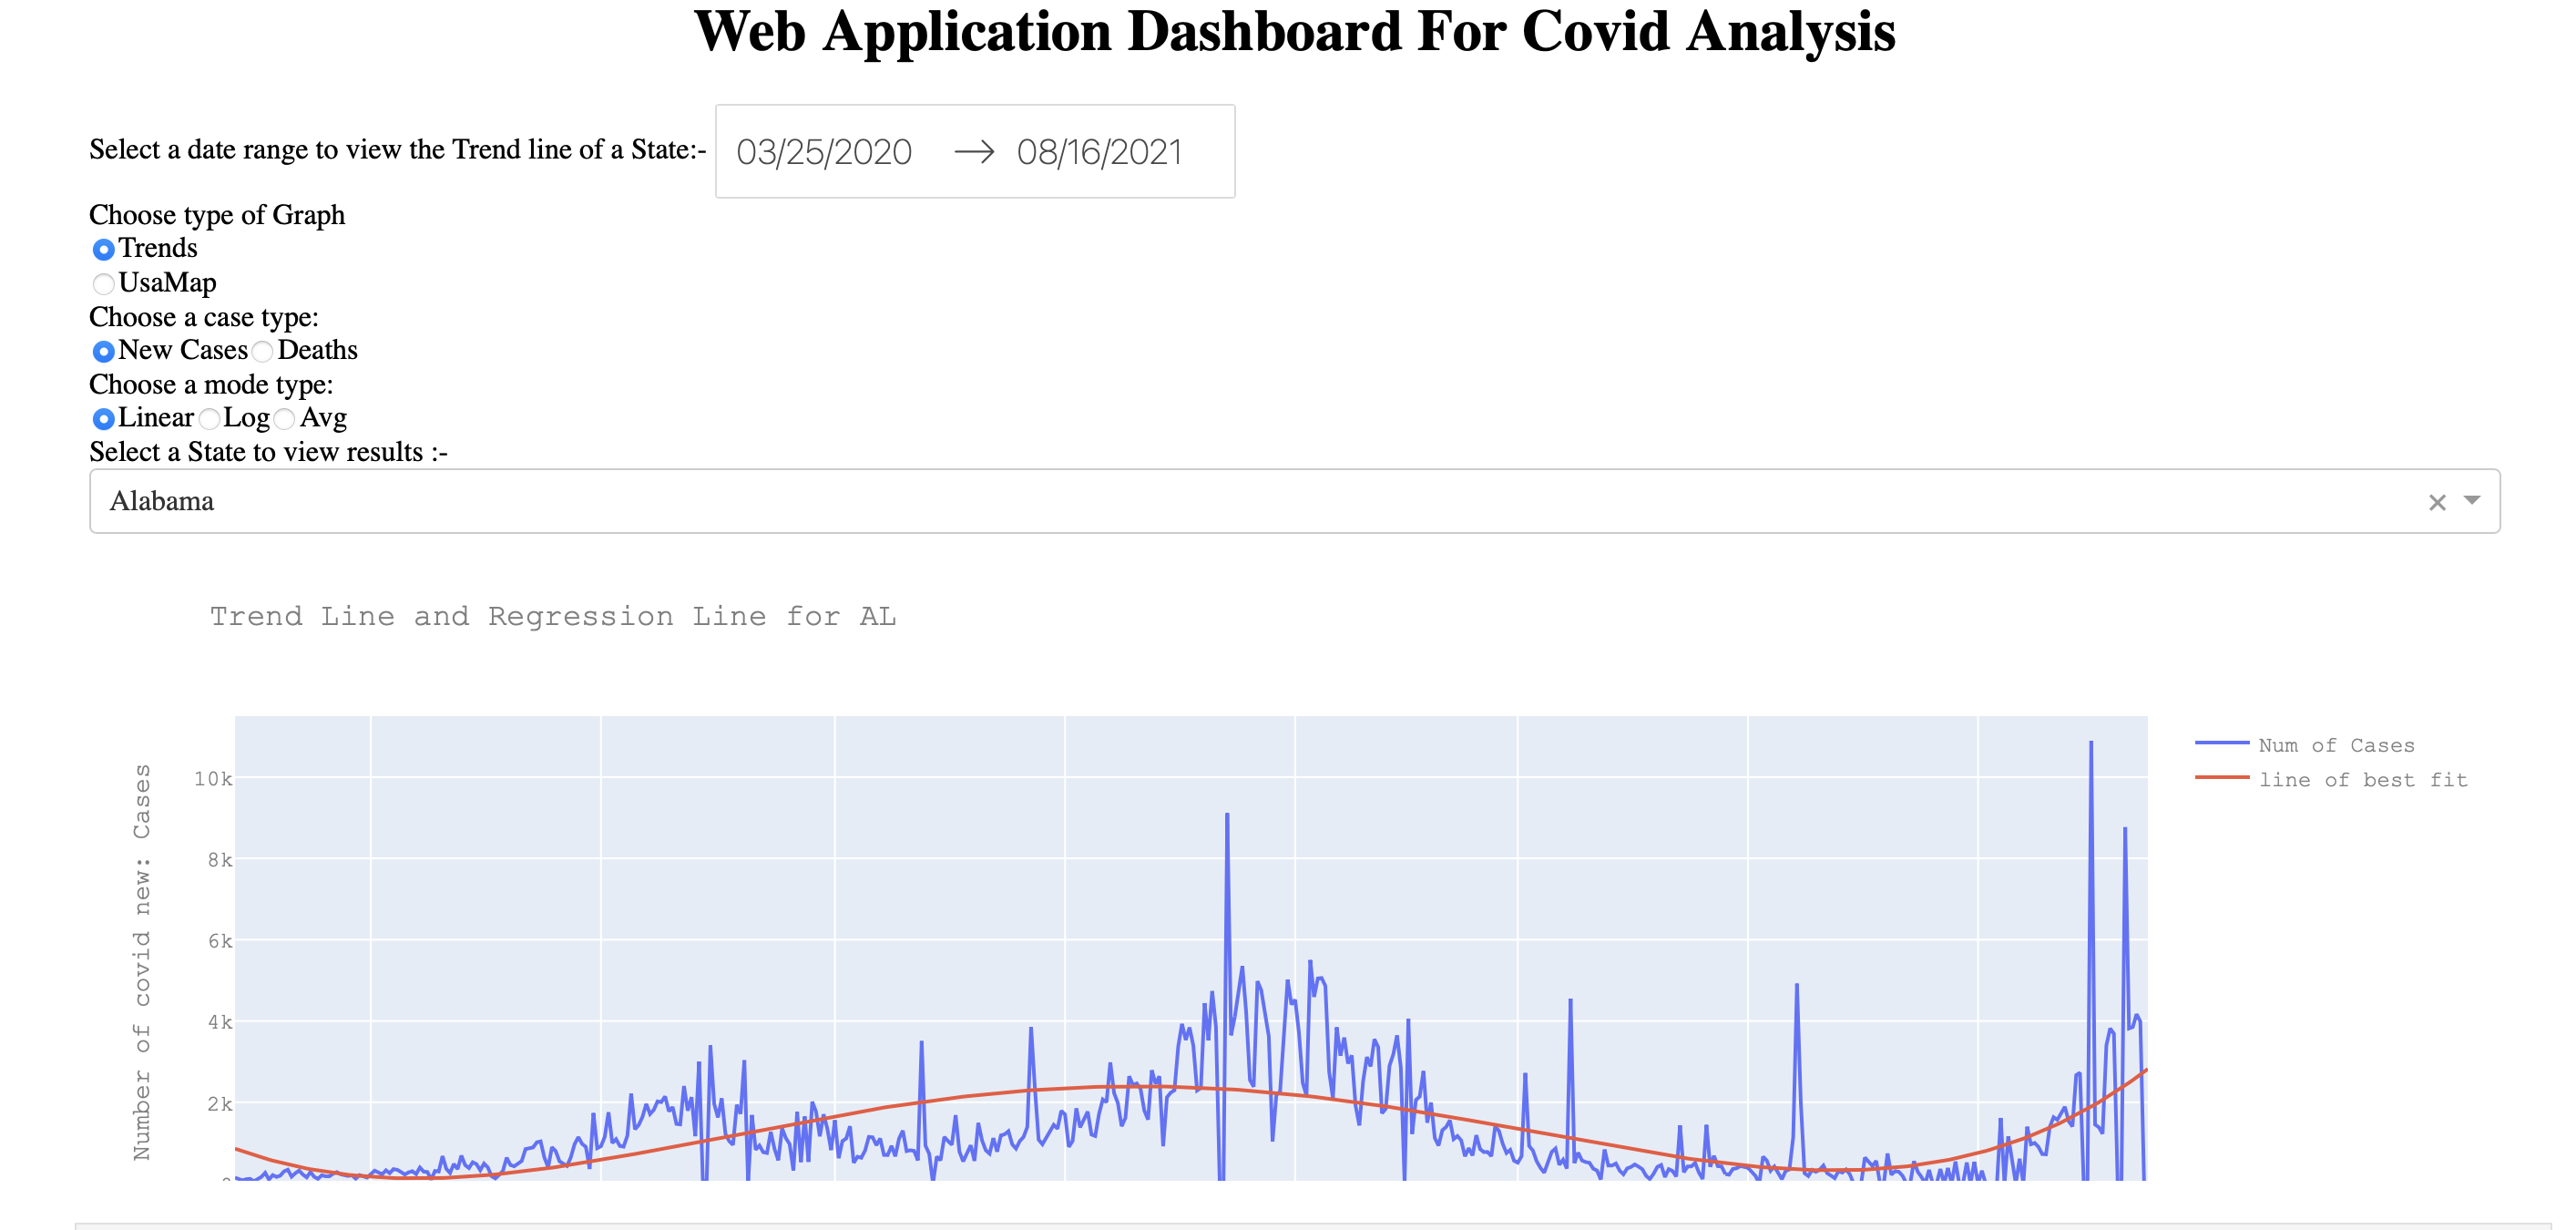

In [15]:
from IPython.display import Image
Image(filename = "images/fig1.png", width=1200, height=600)

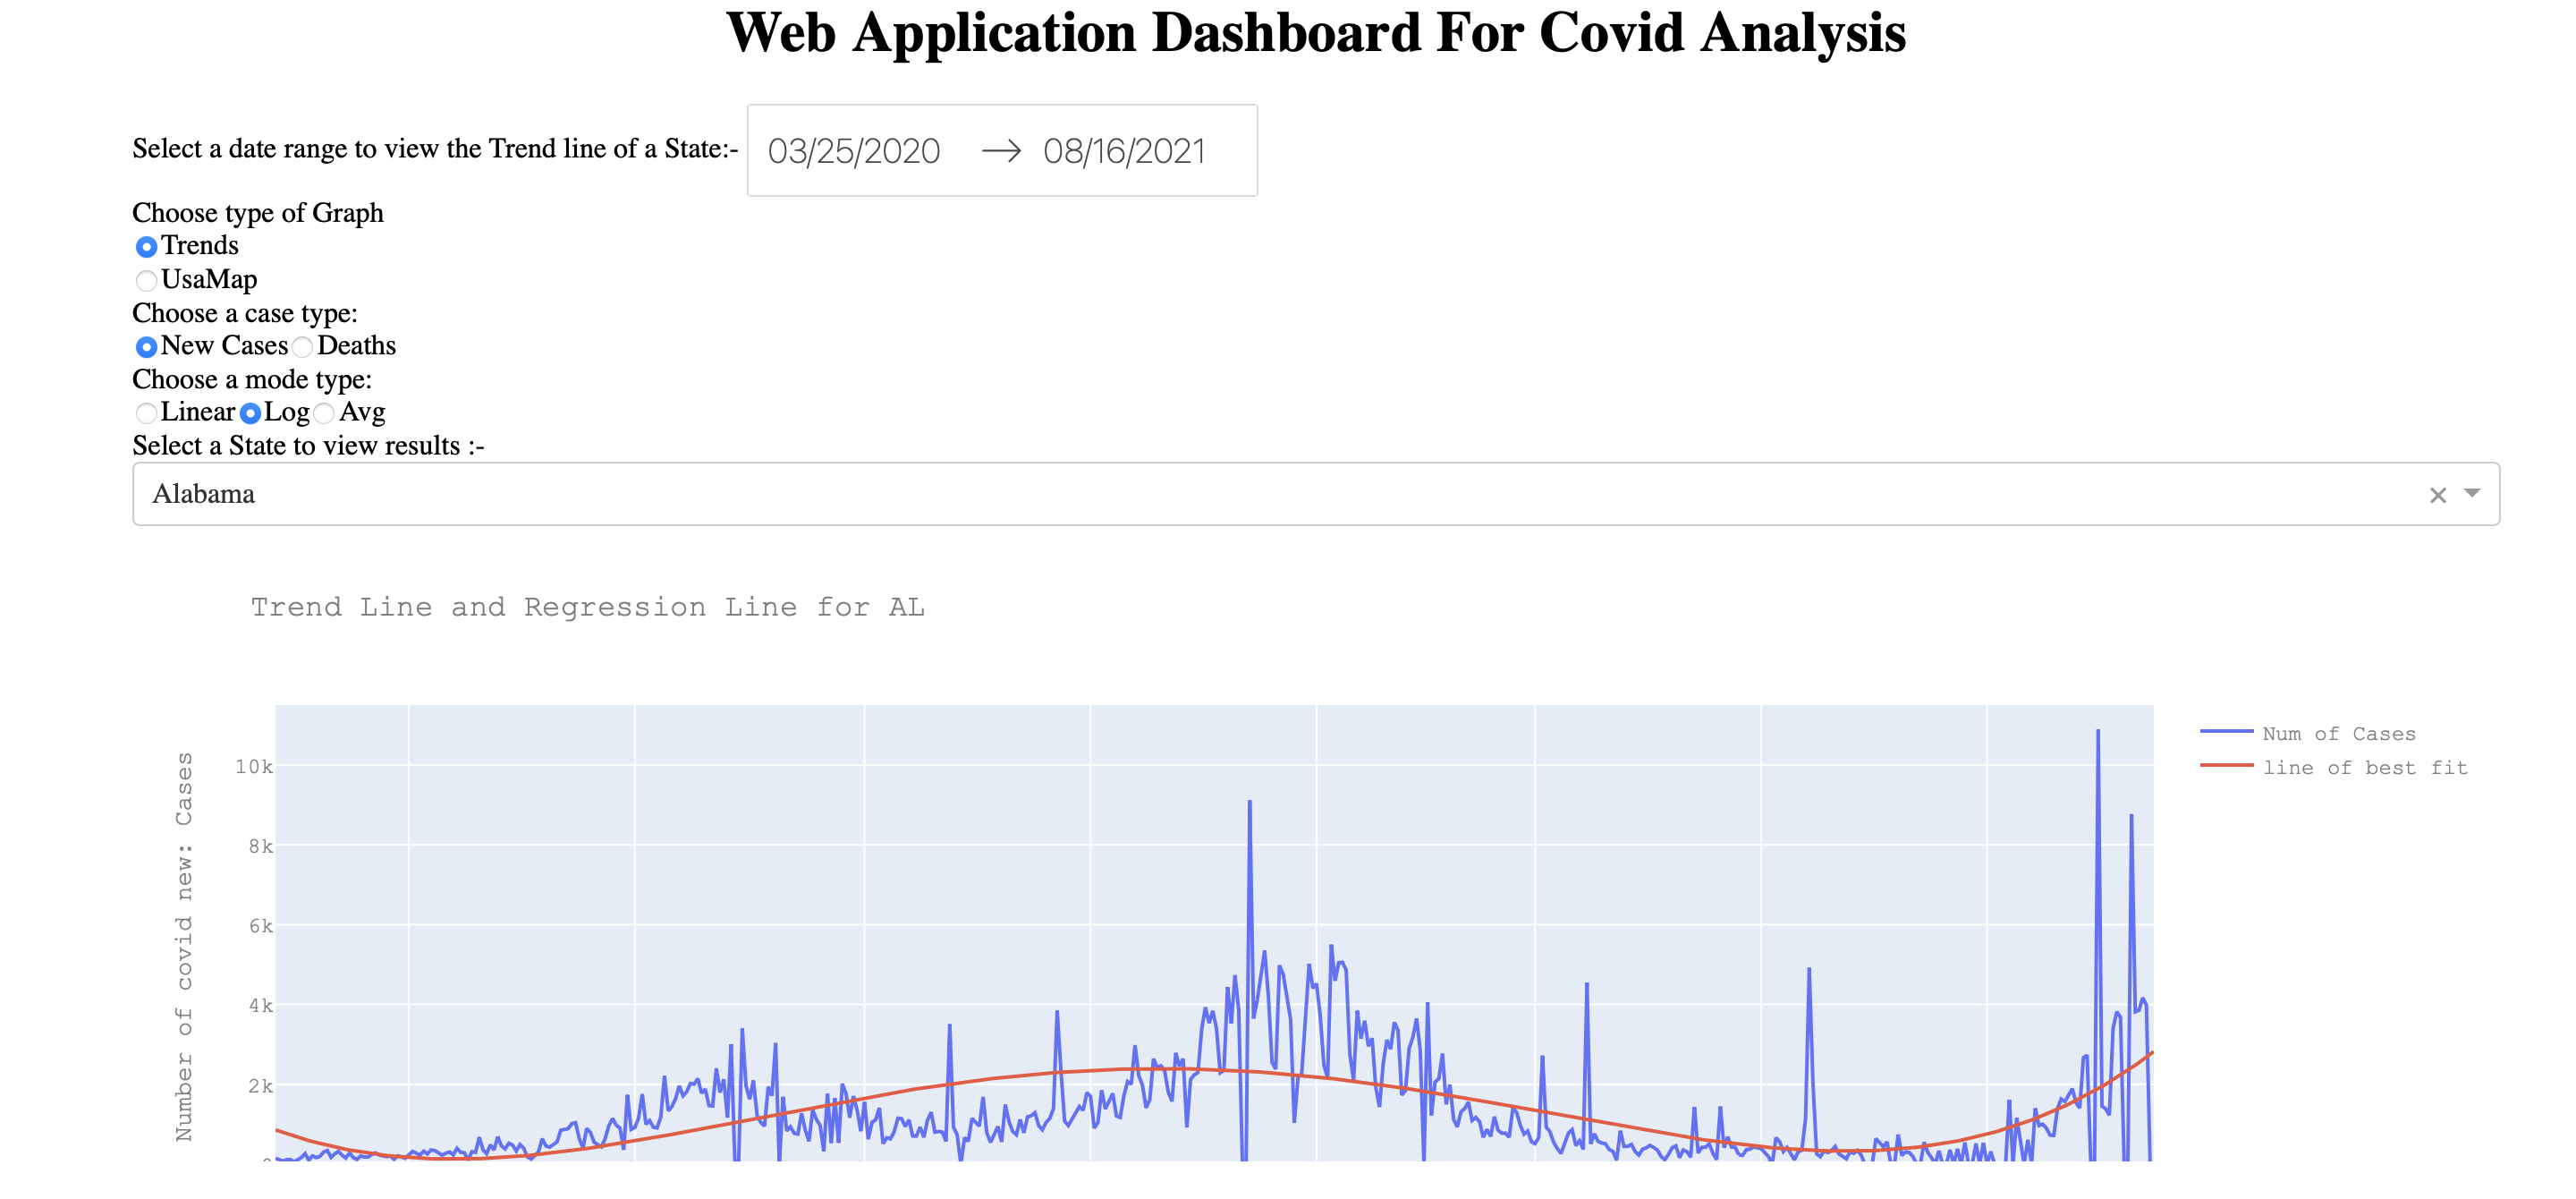

In [16]:
Image(filename = "images/fig2.png", width=1200, height=600)

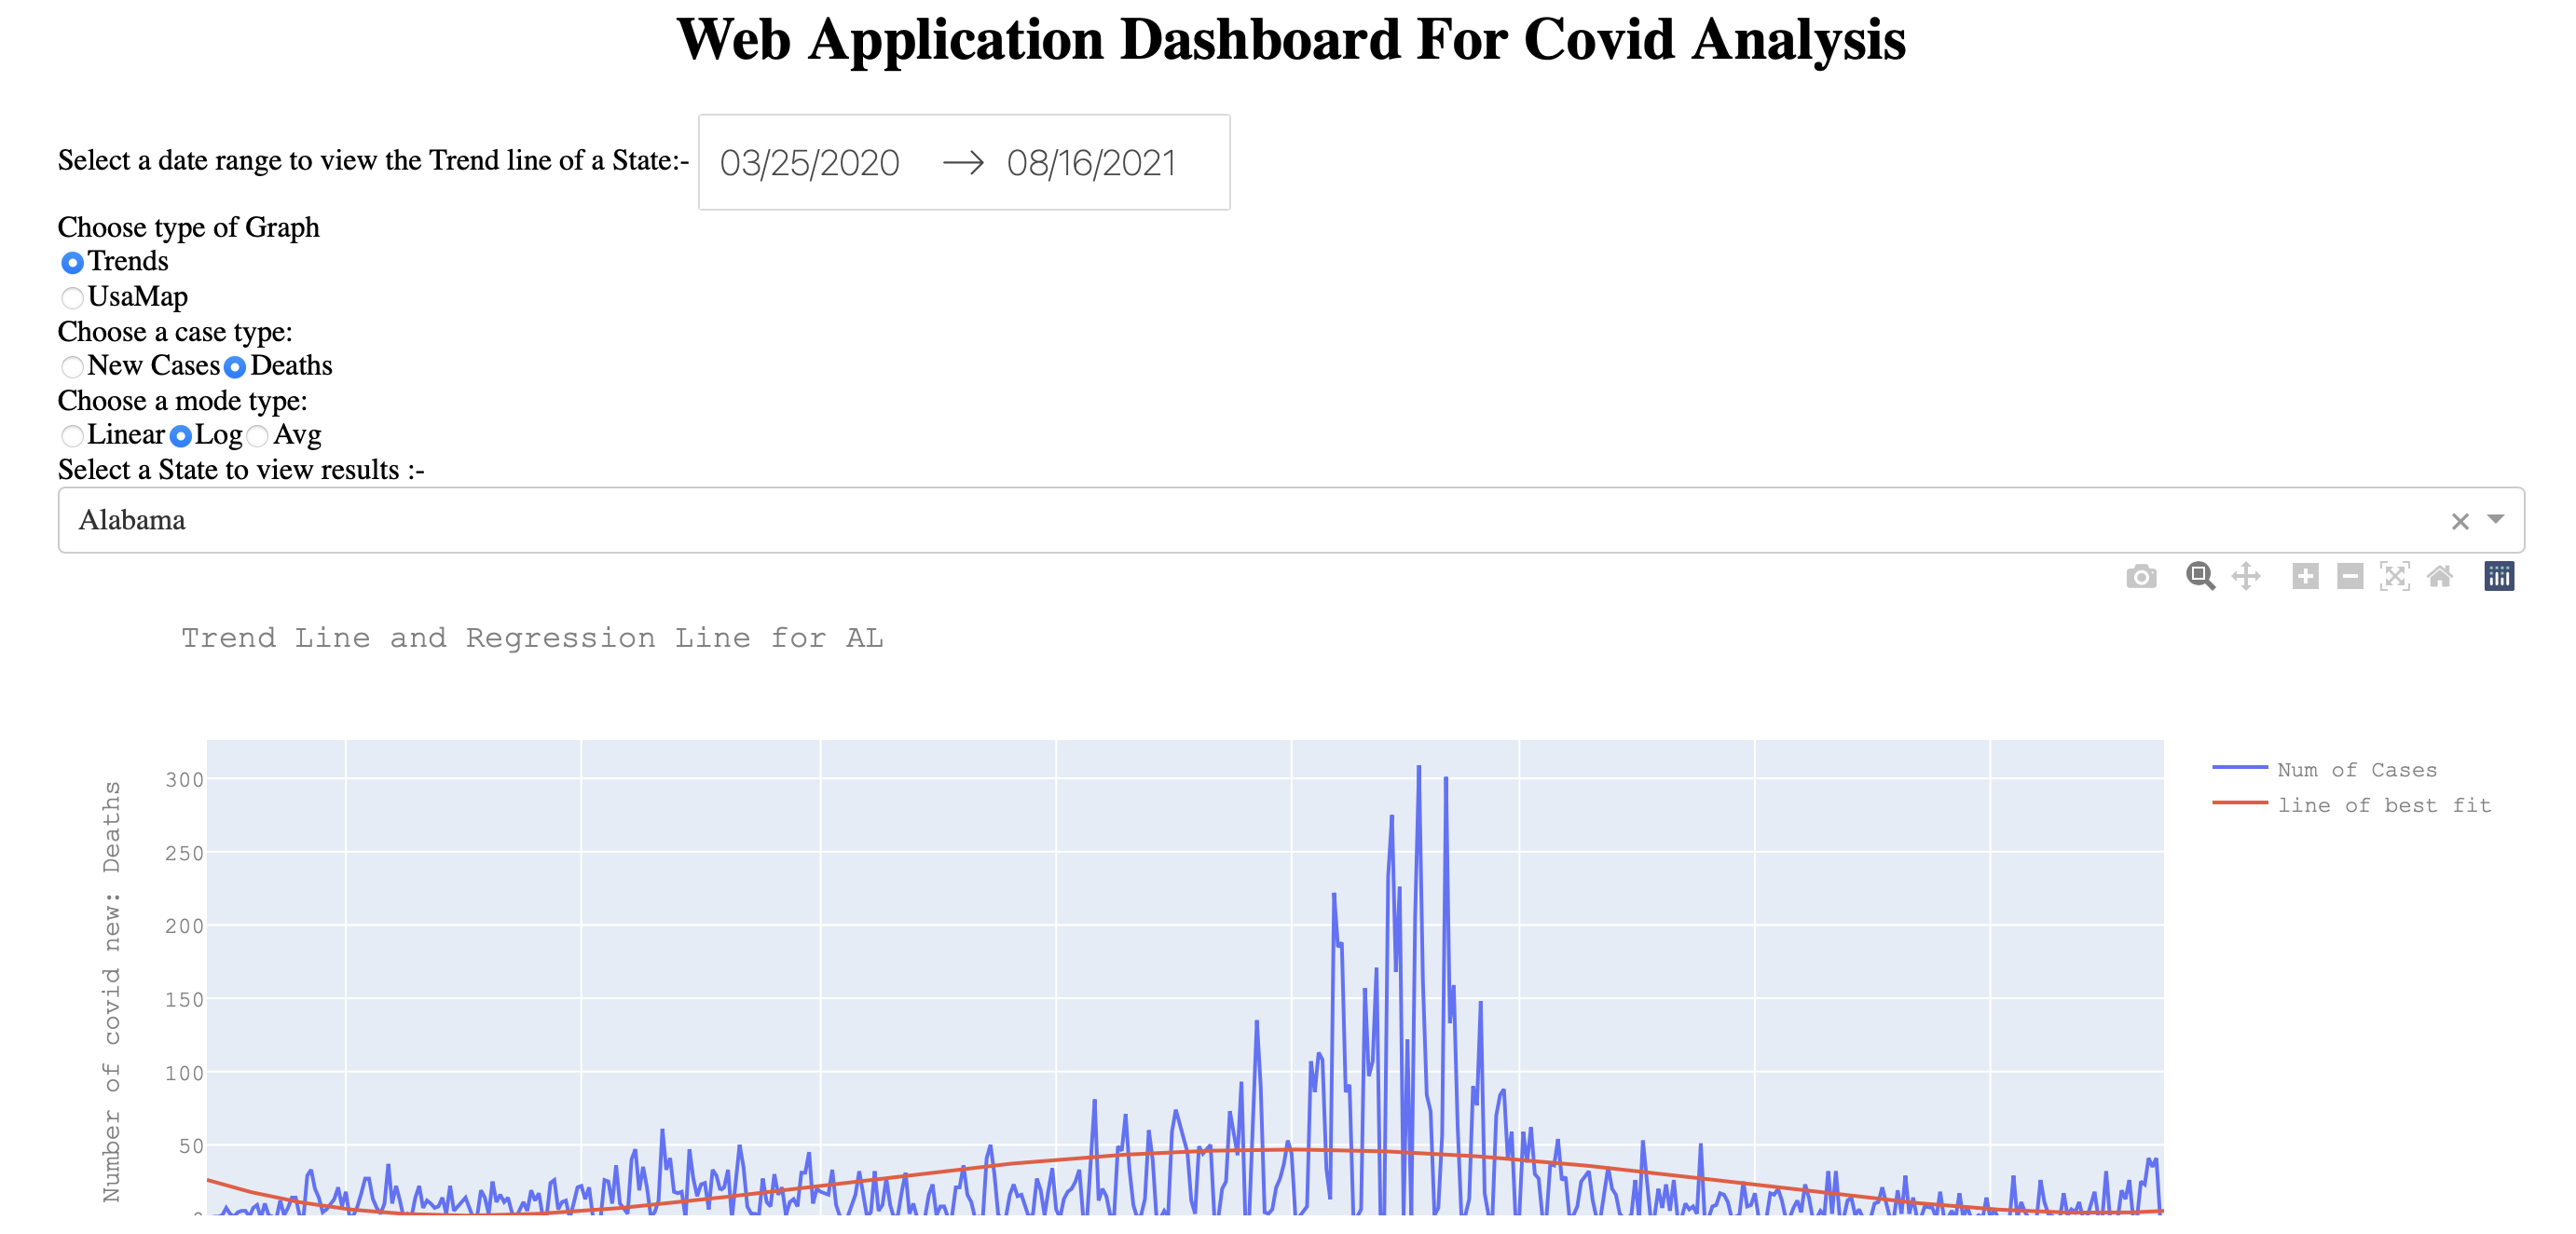

In [17]:
Image(filename = "images/fig3.png", width=1200, height=600)

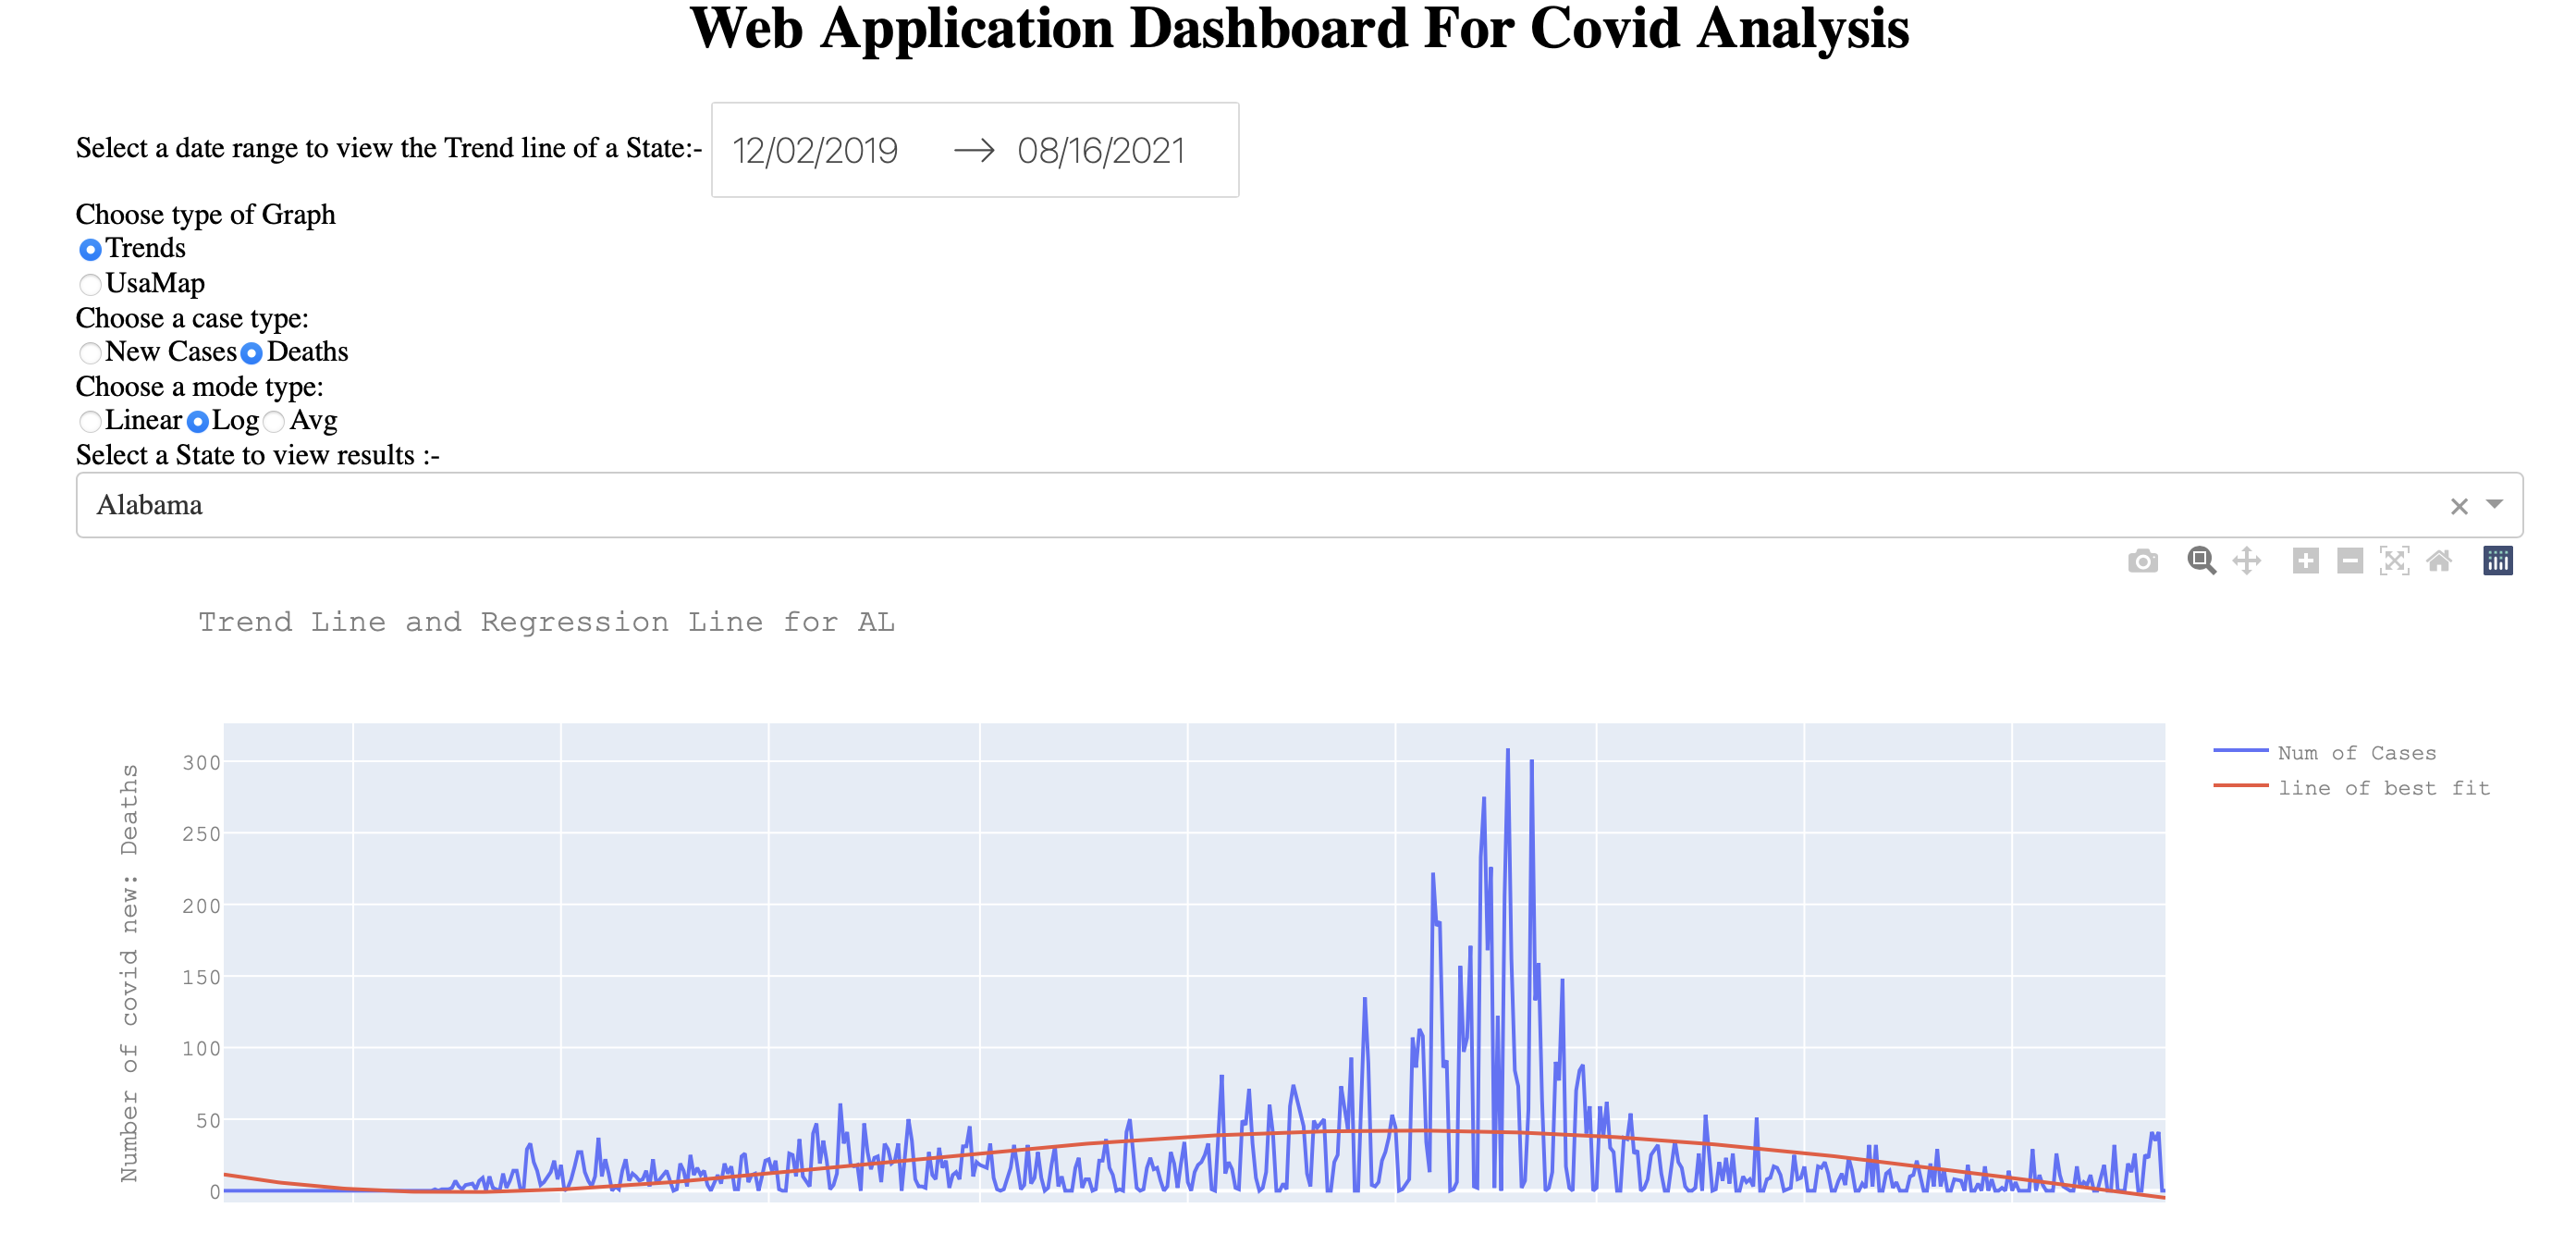

In [18]:
Image(filename = "images/fig4.png", width=1200, height=600)

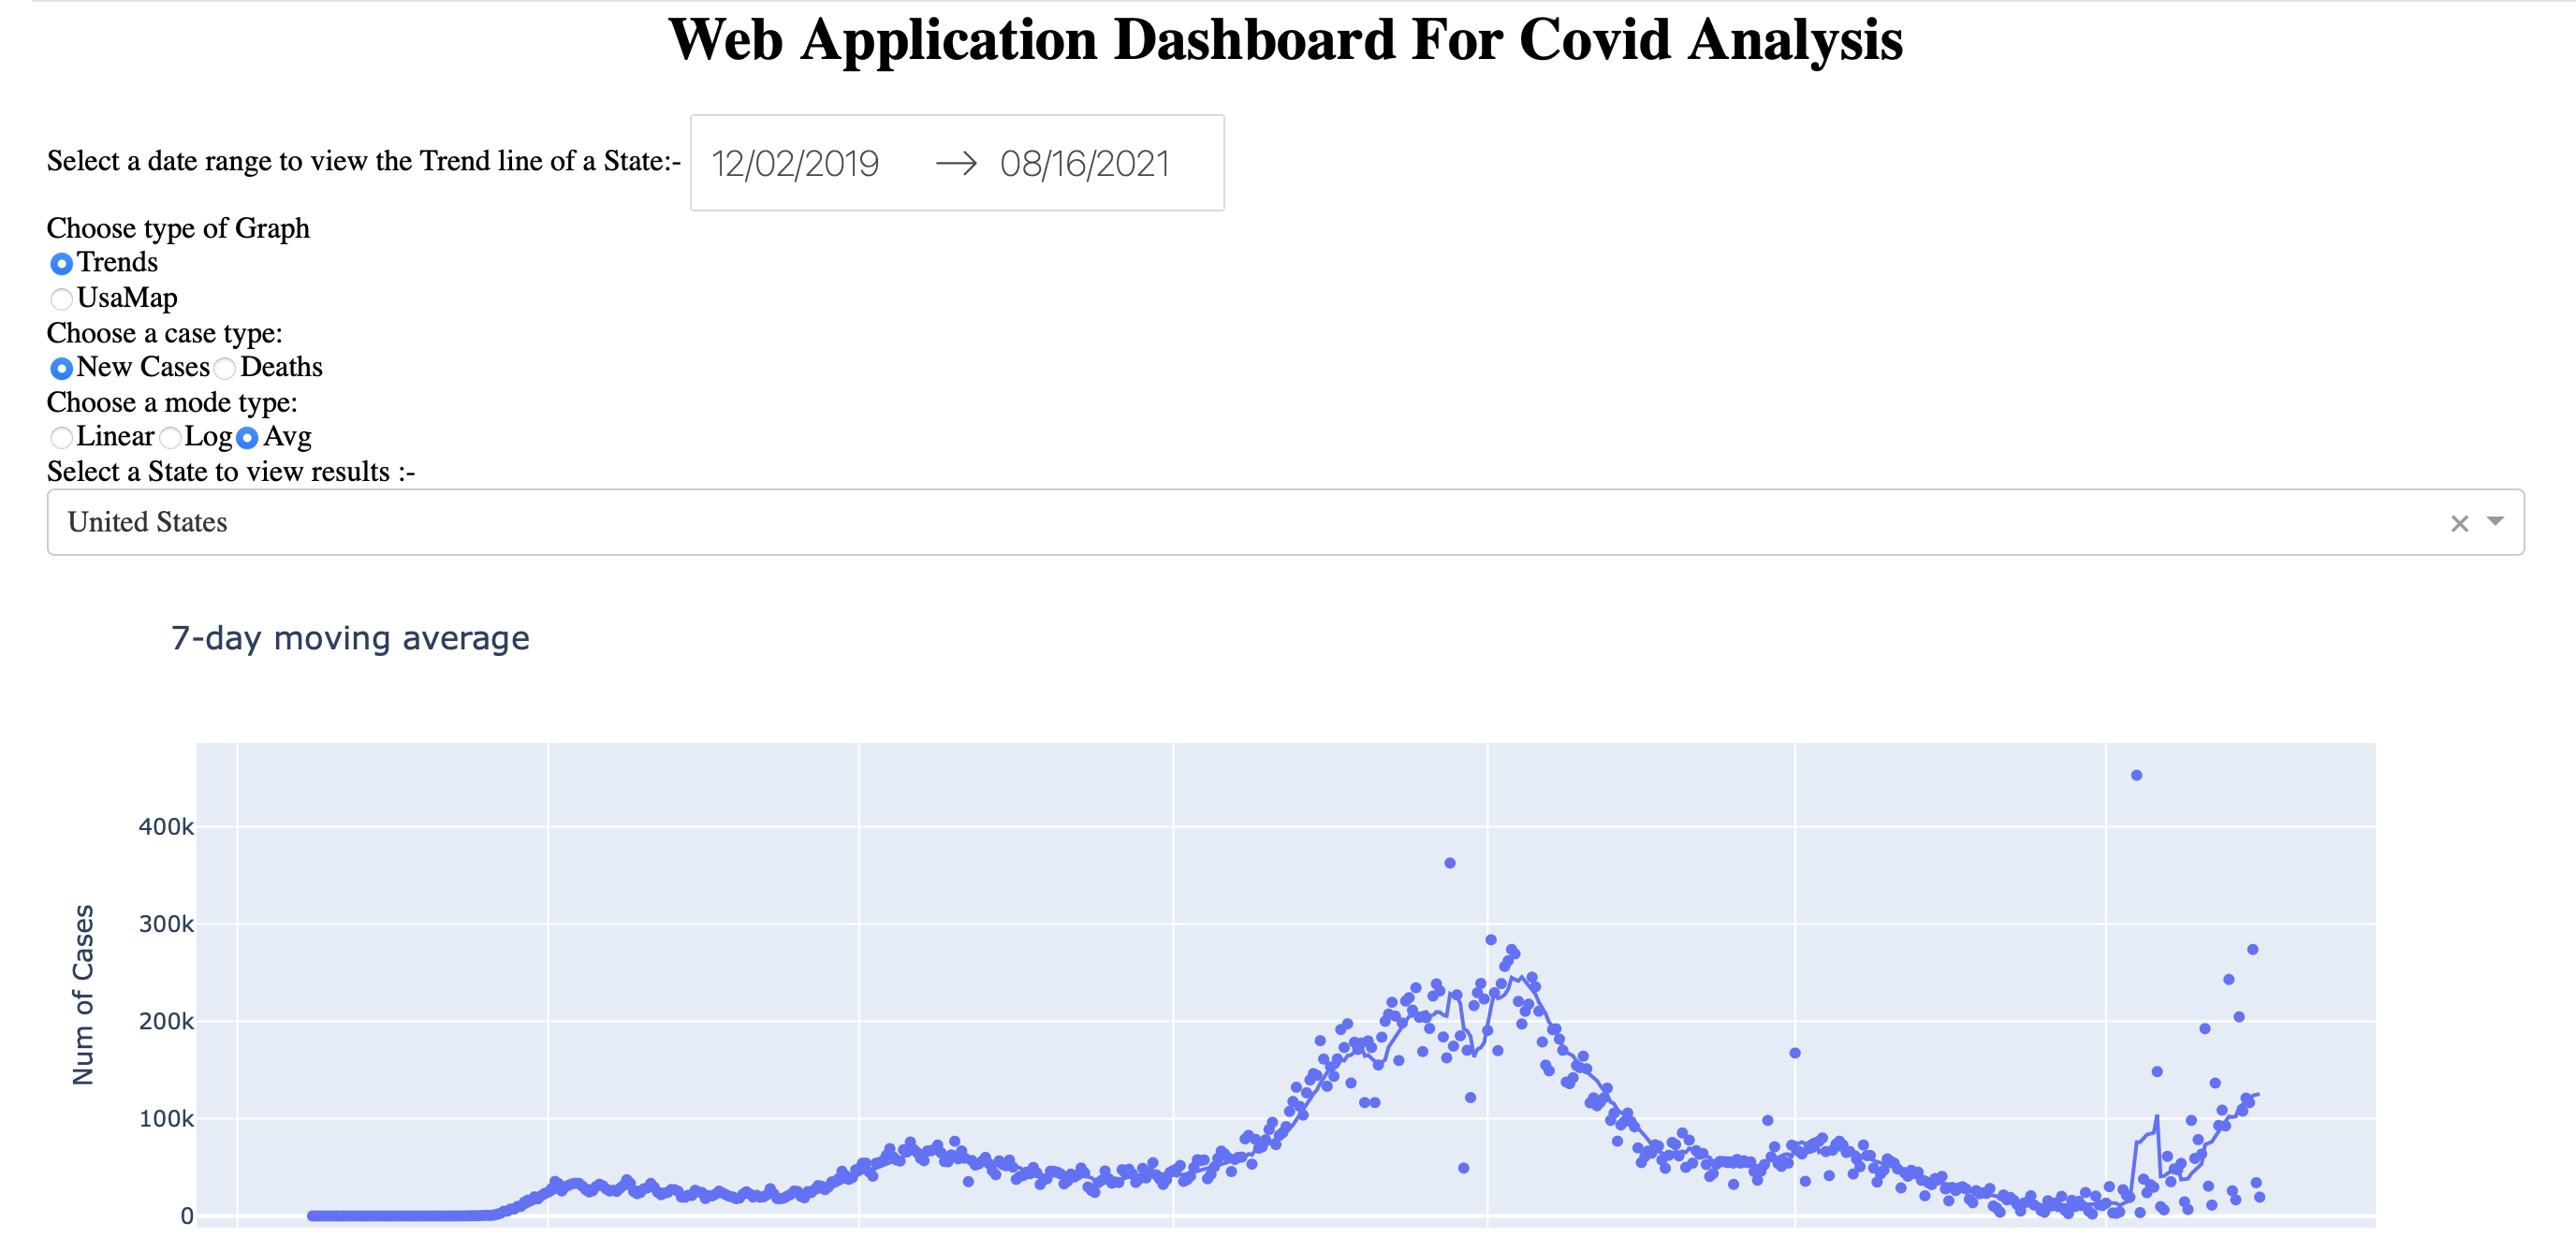

In [19]:
Image(filename = "images/fig5.png", width=1200, height=600)

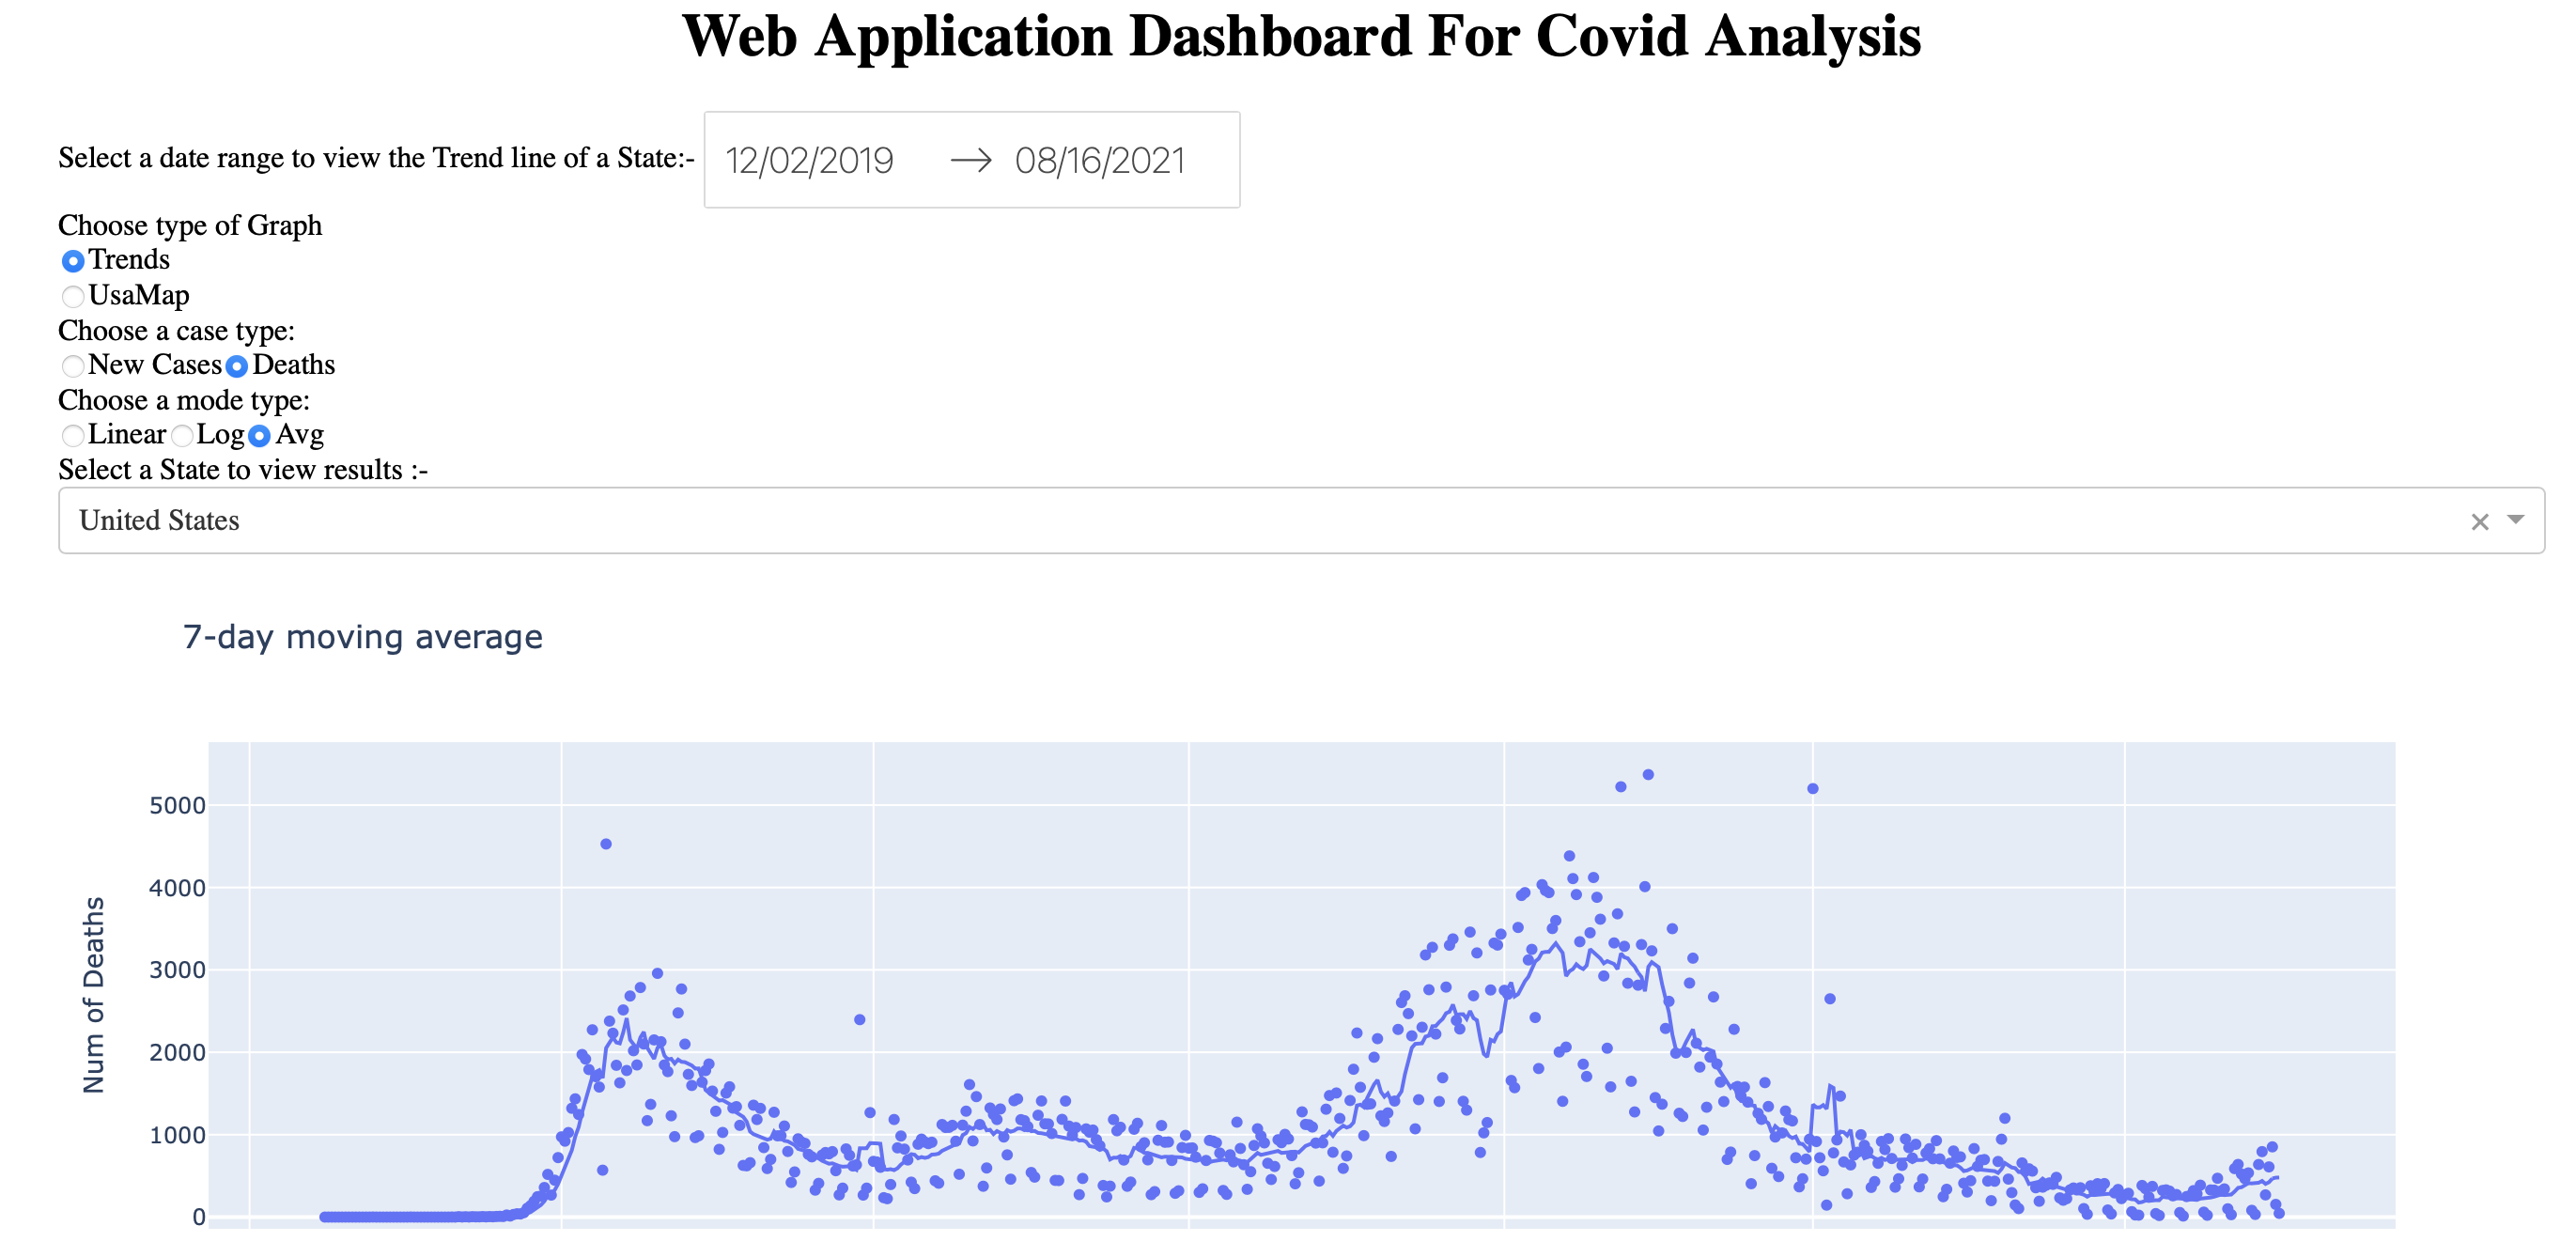

In [20]:
Image(filename = "images/fig6.png", width=1200, height=600)

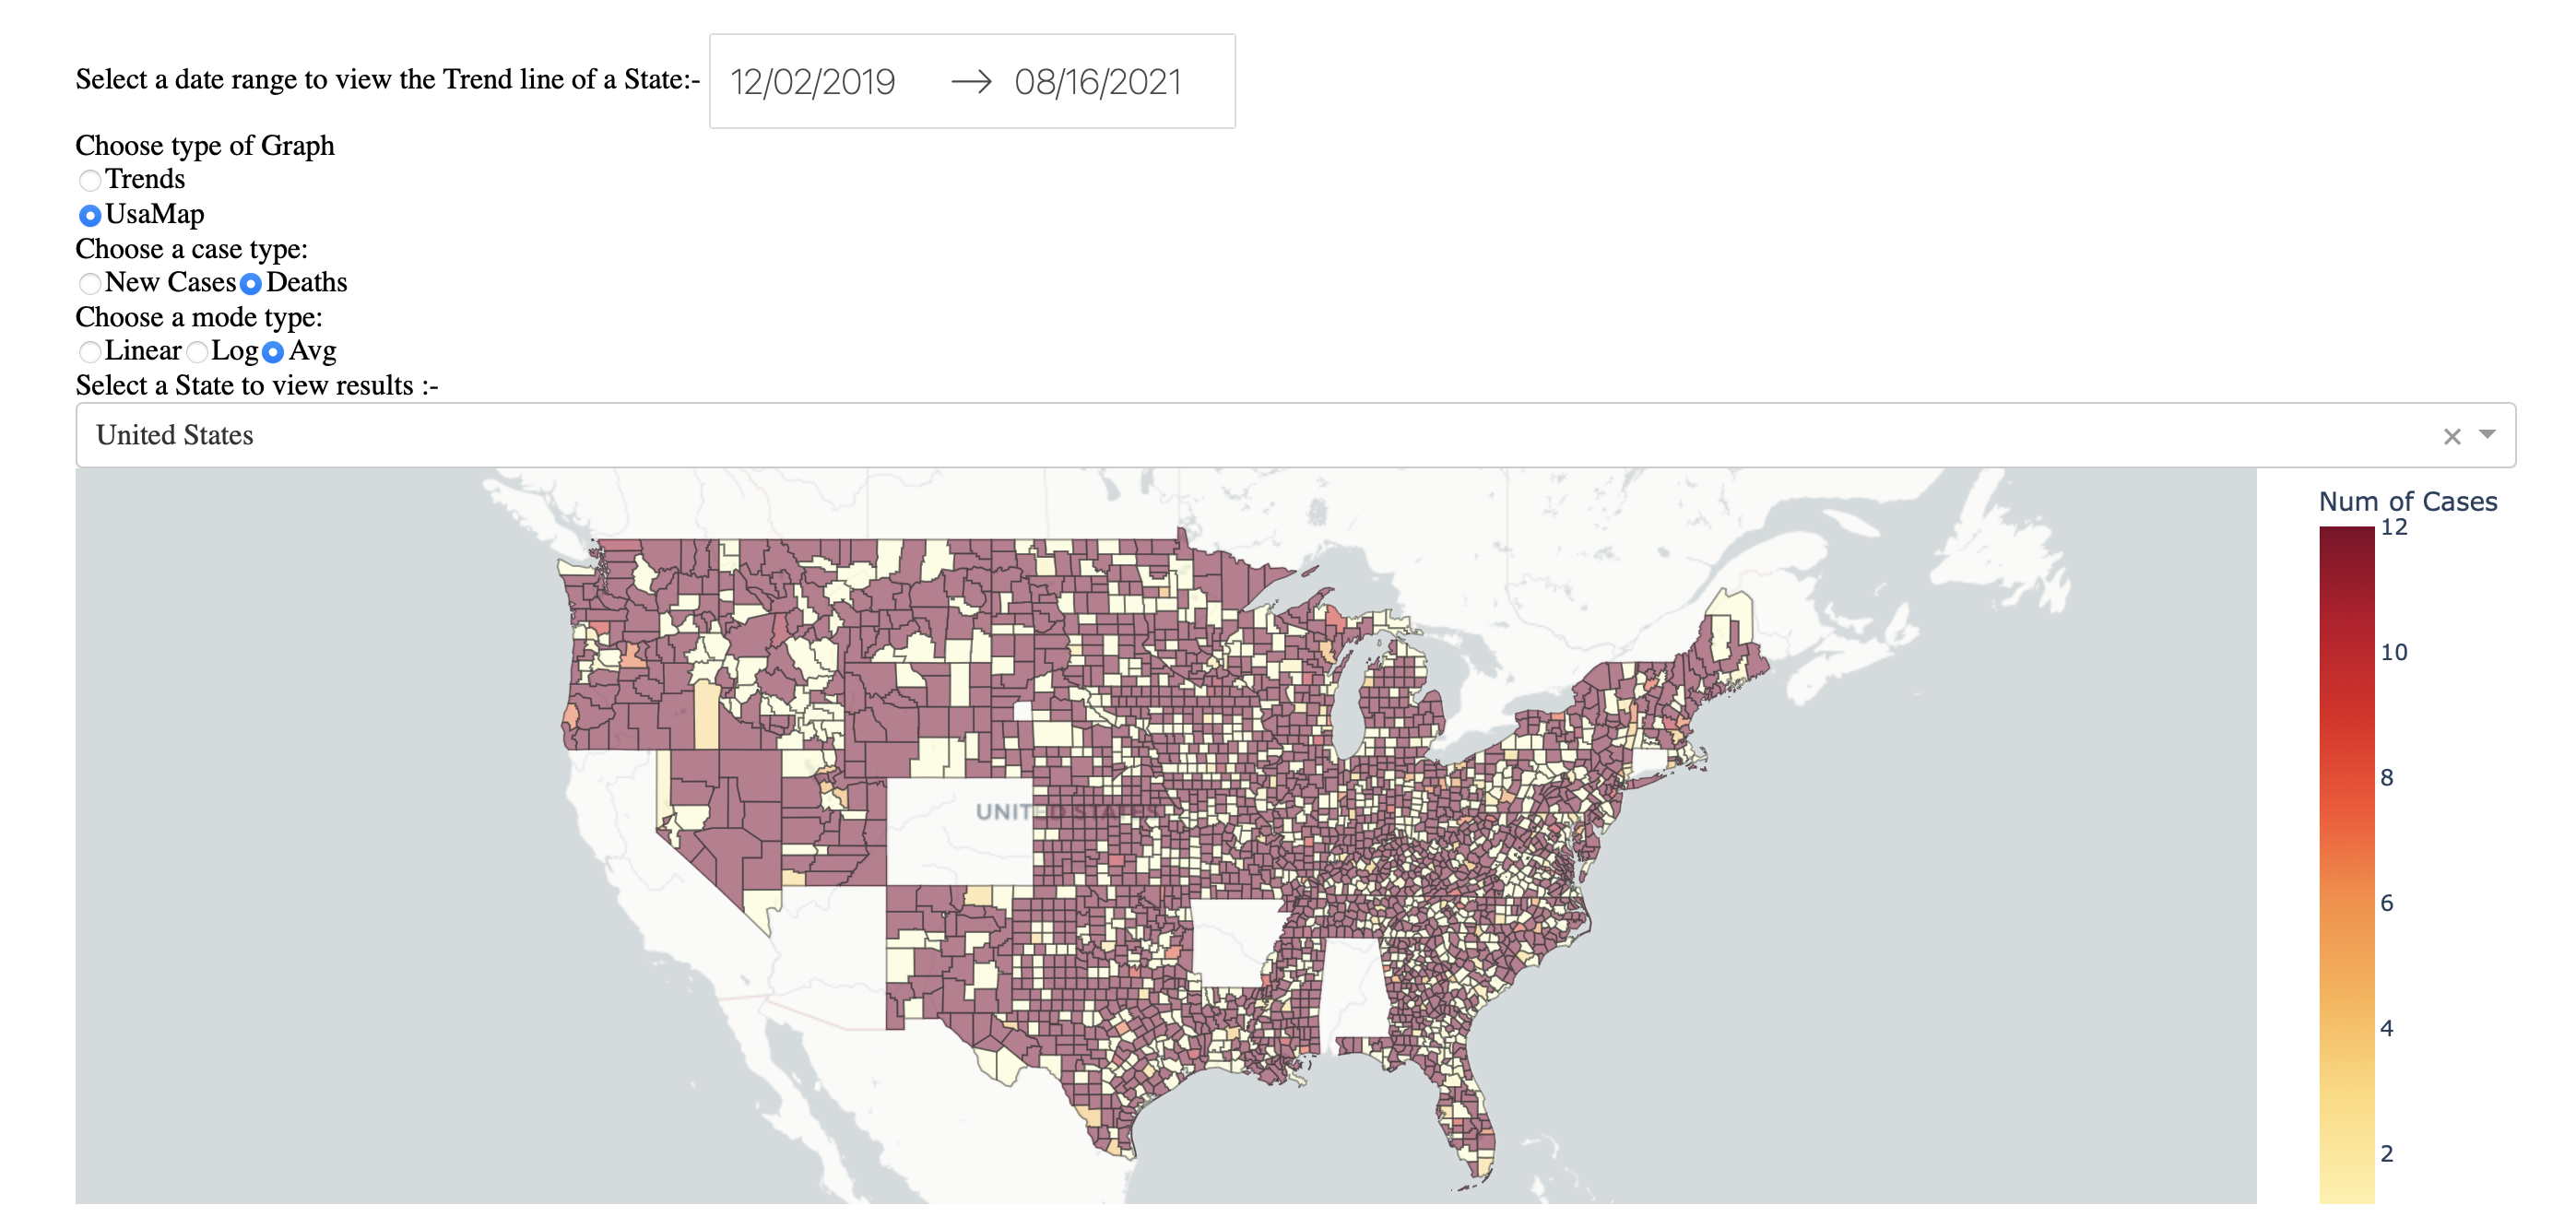

In [21]:
Image(filename = "images/fig7.png", width=1200, height=600)

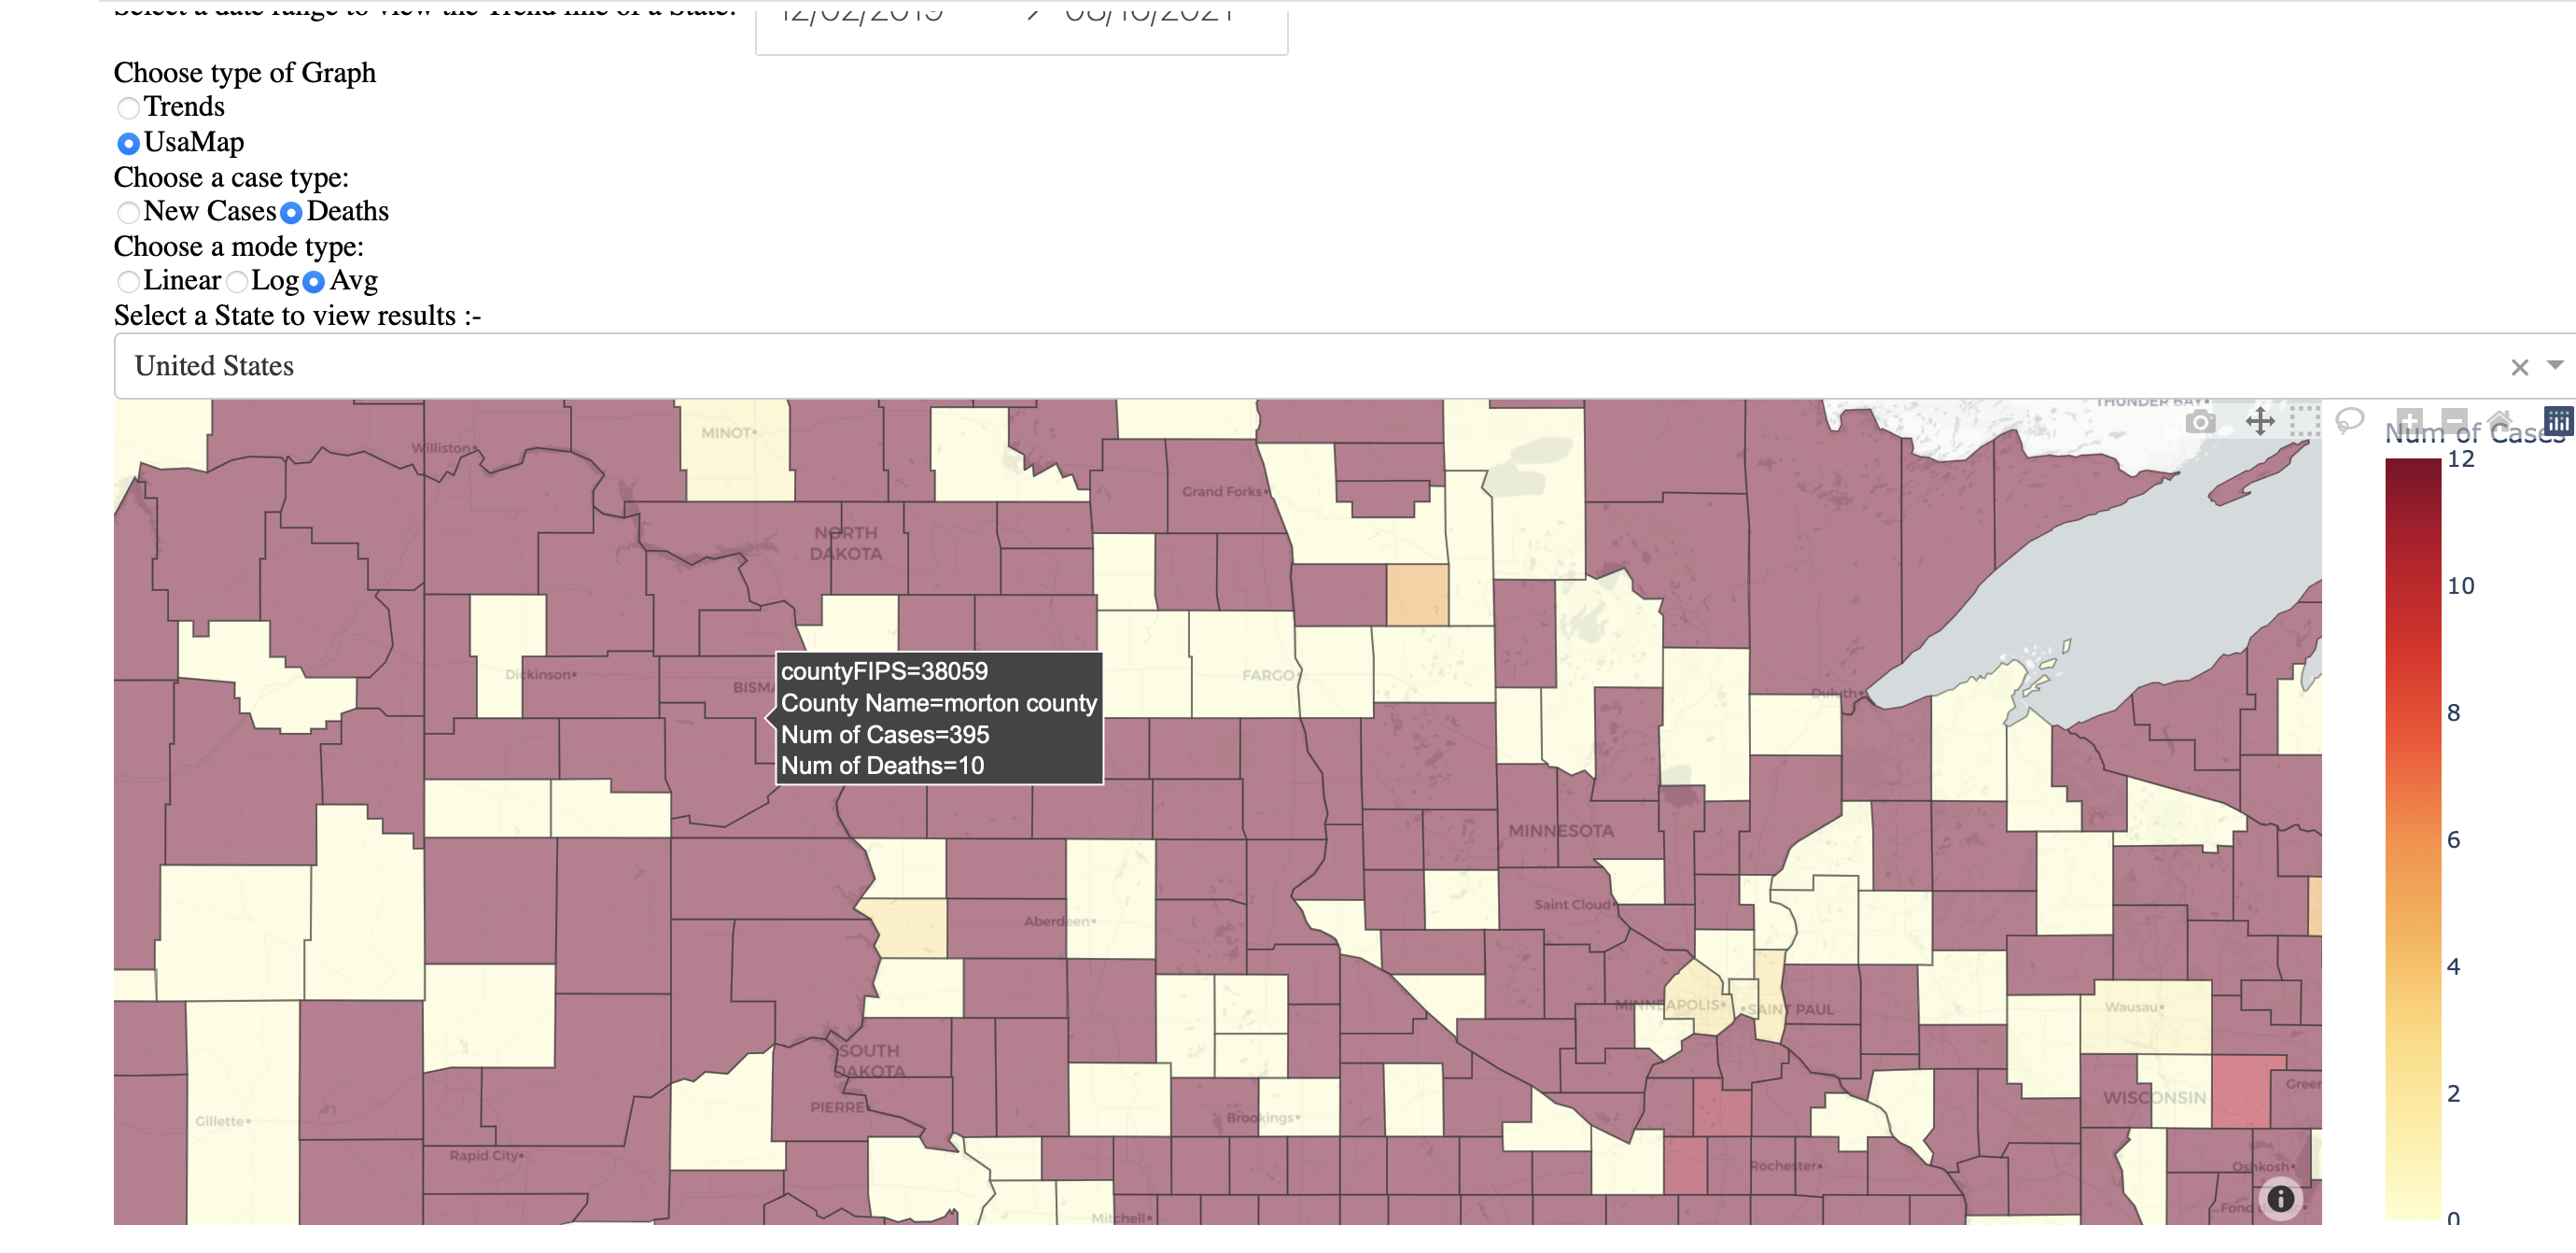

In [22]:
Image(filename = "images/fig8.png", width=1200, height=600)